<a href="https://colab.research.google.com/github/Delonix7/My_Data_Science_Projects/blob/main/PhD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A1/A2 Contribution to Dilutional Hyponatremia in Liver Cirrhosis

##Importing data

In [40]:
import pandas as pd
import matplotlib.pyplot  as plt
%matplotlib inline
import numpy as  np
import seaborn as sns
from scipy.stats import sem
#authenticate colabs to allow access to Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [41]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [42]:
def get_data(url, file_name):
  dataframe_name = pd.DataFrame()
  data_url_list = url.split('/')
  downloaded = drive.CreateFile({'id':data_url_list[5]})
  downloaded.GetContentFile(file_name)
  dataframe_name = pd.read_csv(file_name)
  return dataframe_name

In [43]:
url = 'https://drive.google.com/file/d/1kj6cs2u_ZJR6U0cvCpdwKqOVkhgUhBId/view?usp=sharing'
file_name = 'Sap_project_data.csv'

In [44]:
sap_project_data = get_data(url, file_name)

In [45]:
sap_project_data.head(2)

,Rat ID,Injection,Surgery,L:B ratio,CPP conc,CPP as ratios,Osmolality,Crit,A1 DBH,A1 dFosB,A1 DL,A2 DBH,A2 dFosB,A2 DL,SON_dFosB,SON_DL
0,R19-134,DSAP,BDL,0.056566,111.4885,1.561760,304.0,42.5,43,19,3,24,48,1,46.0,19.0
1,R19-135,DSAP,BDL,0.041700,81.4151,1.342934,298.0,46.5,36,25,0,28,65,2,51.0,29.0


In [46]:
#Replacing spaces in column names with hyphens
sap_project_data.columns = sap_project_data.columns.str.lower()
sap_project_data.columns = sap_project_data.columns.str.replace(' ', '_')

In [47]:
sap_project_data.head(2)

,rat_id,injection,surgery,l:b_ratio,cpp_conc,cpp_as_ratios,osmolality,crit,a1_dbh,a1_dfosb,a1_dl,a2_dbh,a2_dfosb,a2_dl,son_dfosb,son_dl
0,R19-134,DSAP,BDL,0.056566,111.4885,1.561760,304.0,42.5,43,19,3,24,48,1,46.0,19.0
1,R19-135,DSAP,BDL,0.041700,81.4151,1.342934,298.0,46.5,36,25,0,28,65,2,51.0,29.0


In [48]:
sap_project_data.replace('-', np.NaN, inplace = True)

In [49]:
sap_project_data.head(2)

,rat_id,injection,surgery,l:b_ratio,cpp_conc,cpp_as_ratios,osmolality,crit,a1_dbh,a1_dfosb,a1_dl,a2_dbh,a2_dfosb,a2_dl,son_dfosb,son_dl
0,R19-134,DSAP,BDL,0.056566,111.4885,1.561760,304.0,42.5,43,19,3,24,48,1,46.0,19.0
1,R19-135,DSAP,BDL,0.041700,81.4151,1.342934,298.0,46.5,36,25,0,28,65,2,51.0,29.0


In [50]:
DSAP_BDL = sap_project_data.loc[sap_project_data['injection'].str.contains('DSAP') & sap_project_data['surgery'].str.contains('BDL')]
DSAP_Sham = sap_project_data.loc[sap_project_data['injection'].str.contains('DSAP') & sap_project_data['surgery'].str.contains('Sham')]
Veh_BDL = sap_project_data.loc[sap_project_data['injection'].str.contains('Vehicle') & sap_project_data['surgery'].str.contains('BDL')]
Veh_Sham = sap_project_data.loc[sap_project_data['injection'].str.contains('Vehicle') & sap_project_data['surgery'].str.contains('Sham')]

In [51]:
column_names = list(sap_project_data.columns)

In [52]:
column_names

['rat_id',
 'injection',
 'surgery',
 'l:b_ratio',
 'cpp_conc',
 'cpp_as_ratios',
 'osmolality',
 'crit',
 'a1_dbh',
 'a1_dfosb',
 'a1_dl',
 'a2_dbh',
 'a2_dfosb',
 'a2_dl',
 'son_dfosb',
 'son_dl']

In [53]:
column_names.remove('rat_id')
column_names.remove('injection')
column_names.remove('surgery')
column_names.remove('cpp_conc')

In [54]:
groups = [DSAP_Sham, DSAP_BDL, Veh_BDL, Veh_Sham]
for group in groups:
  group.reset_index(inplace = True)

In [55]:
sap_project_data.set_index('rat_id', inplace = True)

In [56]:
class Variables:
  def __init__ (self, df1, df2, df3, df4, var):
    self.df1 = df1
    self.df2 = df2
    self.df3 = df3
    self.df4 = df4
    self.dataframes = [self.df1, self.df2, self.df3, self.df4]
    self.var = var
    self.series = []
    self.new_dataframe = pd.DataFrame(index = range(0, 8))

  @property
  def create_dataframe(self):
    self.new_dataframe = self.new_dataframe.assign(Veh_Sham = Veh_Sham[self.var])
    self.new_dataframe = self.new_dataframe.assign(Veh_BDL = Veh_BDL[self.var])
    self.new_dataframe = self.new_dataframe.assign(DSAP_Sham = DSAP_Sham[self.var])
    self.new_dataframe = self.new_dataframe.assign(DSAP_BDL = DSAP_BDL[self.var])
    return self.new_dataframe

In [57]:
import time

In [58]:
start = time.time()
data = {}
for column in column_names:
  new_object = Variables(DSAP_Sham, DSAP_BDL, Veh_BDL,  Veh_Sham, column)
  data[column] = new_object.create_dataframe
end = time.time()
execution_time = end - start
print(f'The function took {execution_time} to run')

The function took 0.05877184867858887 to run


In [59]:
data.keys()

dict_keys(['l:b_ratio', 'cpp_as_ratios', 'osmolality', 'crit', 'a1_dbh', 'a1_dfosb', 'a1_dl', 'a2_dbh', 'a2_dfosb', 'a2_dl', 'son_dfosb', 'son_dl'])

In [60]:
sap_project_data.corr()

,l:b_ratio,cpp_conc,cpp_as_ratios,osmolality,crit,a1_dbh,a1_dfosb,a1_dl,a2_dbh,a2_dfosb,a2_dl,son_dfosb,son_dl
l:b_ratio,1.000000,0.037342,0.578177,-0.355437,-0.269702,0.120331,0.582780,0.493535,0.211133,0.258672,0.487290,0.539024,0.634863
cpp_conc,0.037342,1.000000,0.121750,-0.418744,-0.030343,-0.044283,0.038741,0.034777,-0.151652,-0.416312,-0.041104,0.100154,0.121512
cpp_as_ratios,0.578177,0.121750,1.000000,-0.518832,-0.390659,0.212521,0.300912,0.328731,0.077314,0.190467,0.484058,0.324081,0.563652
osmolality,-0.355437,-0.418744,-0.518832,1.000000,0.378113,-0.281094,-0.382430,-0.338847,-0.151953,0.124562,-0.448561,-0.456745,-0.596742
crit,-0.269702,-0.030343,-0.390659,0.378113,1.000000,-0.358924,-0.306878,-0.553596,-0.196291,-0.092389,-0.327472,-0.574453,-0.574786
a1_dbh,0.120331,-0.044283,0.212521,-0.281094,-0.358924,1.000000,0.386013,0.249341,0.469848,0.298032,0.379540,0.289118,0.324558
a1_dfosb,0.582780,0.038741,0.300912,-0.382430,-0.306878,0.386013,1.000000,0.611793,0.560536,0.447397,0.681337,0.787277,0.804125
a1_dl,0.493535,0.034777,0.328731,-0.338847,-0.553596,0.249341,0.611793,1.000000,0.398485,0.226100,0.582261,0.732345,0.746854
a2_dbh,0.211133,-0.151652,0.077314,-0.151953,-0.196291,0.469848,0.560536,0.398485,1.000000,0.608252,0.635586,0.417288,0.435601
a2_dfosb,0.258672,-0.416312,0.190467,0.124562,-0.092389,0.298032,0.447397,0.226100,0.608252,1.000000,0.443702,0.287372,0.305821


In [61]:
def draw_scatter(x, y, data):
  plt.scatter(x = data[x], y = data[y])
  plt.xlabel(f'{x}')
  plt.ylabel(f'{y}')
  plt.title(f'{x} vs {y}')
  plt.show()

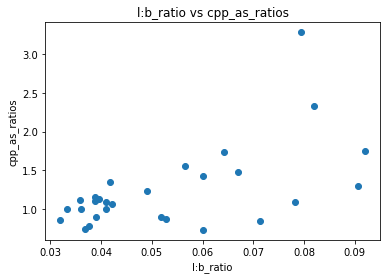

In [62]:
draw_scatter('l:b_ratio', 'cpp_as_ratios', sap_project_data)

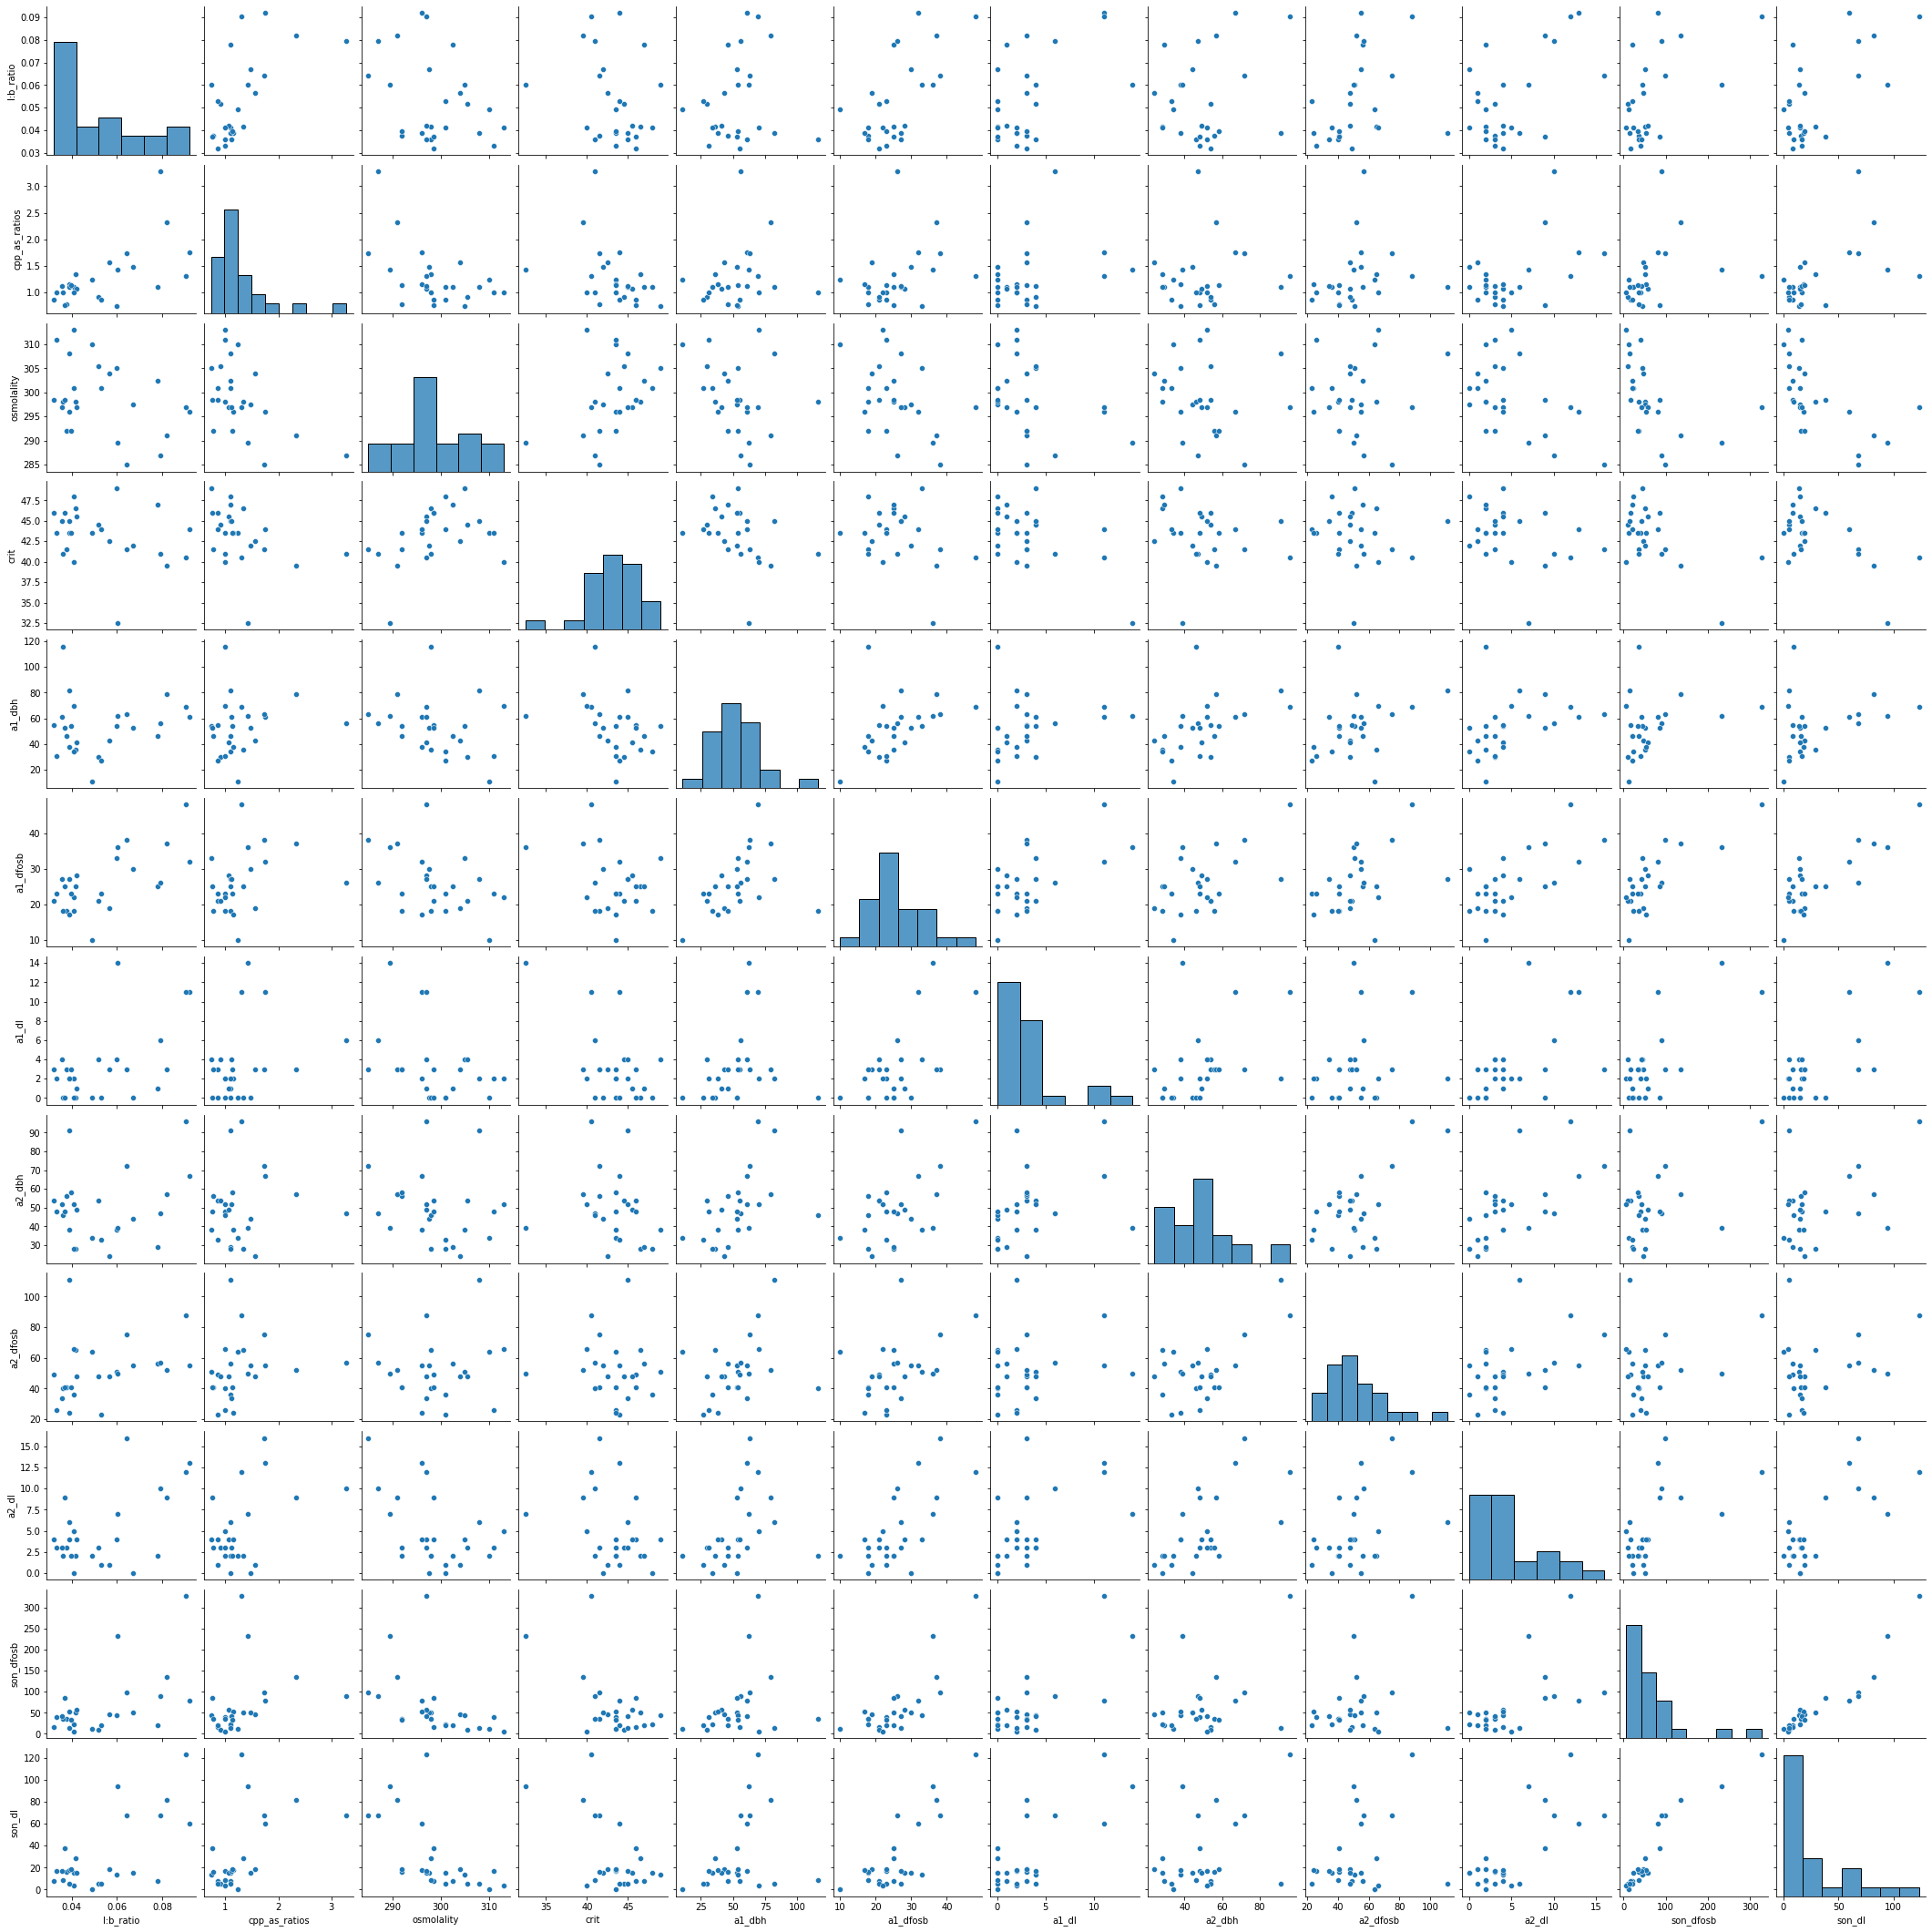

In [63]:
sap_project_data_pair = sap_project_data[column_names].copy()
sns.pairplot(sap_project_data_pair.dropna())

In [64]:
sap_project_data_scatter = pd.DataFrame()
sap_project_data_scatter['Treatment'] = sap_project_data['injection'] +'_'+ sap_project_data['surgery']
for column in column_names:
  sap_project_data_scatter[column] = sap_project_data[column]

sap_project_data_scatter['Treatment'].replace({'Vehicle_BDL': 'Veh_BDL'}, inplace =True)
sap_project_data_scatter['Treatment'].replace({'Vehicle_Sham': 'Veh_Sham'}, inplace =True)

In [65]:
def draw_graphs(data, variable):
  data_y = []
  data_y_error = []
  data_x = list(sap_project_data_scatter['Treatment'].unique())
  for data1 in data_x:
    data_y.append(data[variable][data1].dropna().mean())
    data_y_error.append(sem(data[variable][data1].dropna()))

  plt.bar(data_x,  data_y,  color = ['slategray', 'lightcoral', 'slateblue', 'tan'])
  sns.swarmplot(x = 'Treatment',y = variable, data = sap_project_data_scatter, zorder = 2, color = 'black', size = 7)
  plt.errorbar(x =data_x, y=data_y, yerr =data_y_error, fmt = 'o' , color = 'black', capsize = 10)
  plt.ylabel(f'{variable}', size =7)
  plt.title(f'Graph for {variable}')
  plt.show()
  print(f'\n\nTwo-Way ANOVA for {variable}')
  model = ols(f"sap_project_data['{column}']  ~ sap_project_data['surgery'] + sap_project_data['injection'] + sap_project_data['surgery']: sap_project_data['injection']", data = sap_project_data).fit()
  display(sm.stats.anova_lm(model, typ = 2))
 

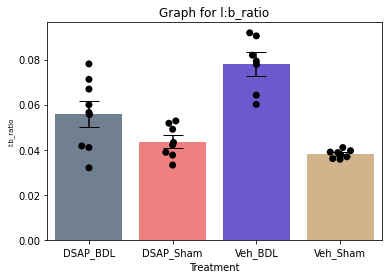



Two-Way ANOVA for l:b_ratio


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],0.004387,1.0,33.806475,0.000005
sap_project_data['injection'],0.000461,1.0,3.551646,0.071654
sap_project_data['surgery']:sap_project_data['injection'],0.001320,1.0,10.169498,0.003945
Residual,0.003114,24.0,NaN,NaN


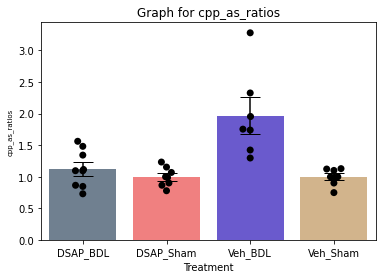



Two-Way ANOVA for cpp_as_ratios


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],1.871554,1.0,12.349992,0.001779
sap_project_data['injection'],1.205224,1.0,7.953021,0.009476
sap_project_data['surgery']:sap_project_data['injection'],1.230333,1.0,8.118709,0.008851
Residual,3.637030,24.0,NaN,NaN


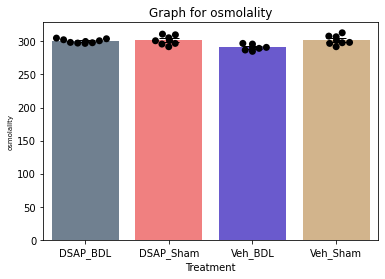



Two-Way ANOVA for osmolality


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],236.813417,1.0,6.785728,0.015530
sap_project_data['injection'],149.116348,1.0,4.272828,0.049675
sap_project_data['surgery']:sap_project_data['injection'],161.742283,1.0,4.634616,0.041599
Residual,837.569940,24.0,NaN,NaN


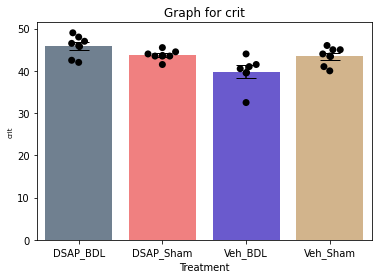



Two-Way ANOVA for crit


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],2.806374,1.0,0.412125,0.527240
sap_project_data['injection'],60.692363,1.0,8.912864,0.006612
sap_project_data['surgery']:sap_project_data['injection'],56.700952,1.0,8.326713,0.008346
Residual,156.619048,23.0,NaN,NaN


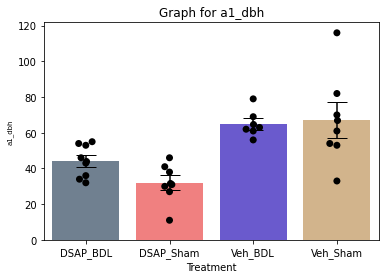



Two-Way ANOVA for a1_dbh


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],216.228575,1.0,0.877659,0.358176
sap_project_data['injection'],5436.000736,1.0,22.064396,0.000090
sap_project_data['surgery']:sap_project_data['injection'],345.552835,1.0,1.402578,0.247889
Residual,5912.875000,24.0,NaN,NaN


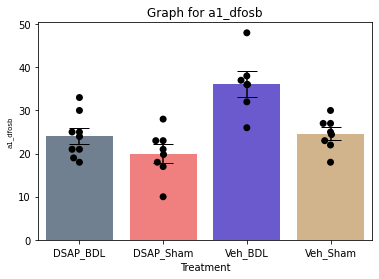



Two-Way ANOVA for a1_dfosb


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],394.196175,1.0,12.571574,0.001645
sap_project_data['injection'],480.754050,1.0,15.332049,0.000652
sap_project_data['surgery']:sap_project_data['injection'],99.912617,1.0,3.186380,0.086900
Residual,752.547619,24.0,NaN,NaN


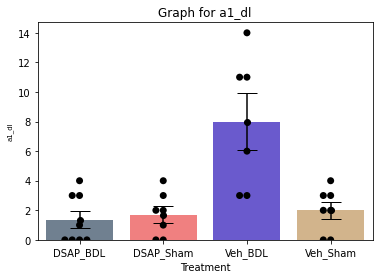



Two-Way ANOVA for a1_dl


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],47.136018,1.0,7.284214,0.012537
sap_project_data['injection'],81.166421,1.0,12.543138,0.001662
sap_project_data['surgery']:sap_project_data['injection'],69.601436,1.0,10.755931,0.003165
Residual,155.303571,24.0,NaN,NaN


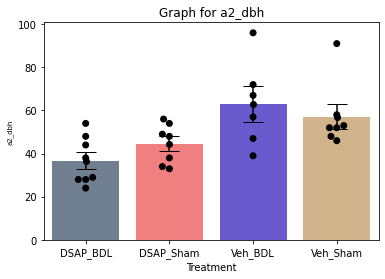



Two-Way ANOVA for a2_dbh


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],16.574242,1.0,0.081639,0.777540
sap_project_data['injection'],2608.191458,1.0,12.847057,0.001495
sap_project_data['surgery']:sap_project_data['injection'],330.004971,1.0,1.625491,0.214533
Residual,4872.446429,24.0,NaN,NaN


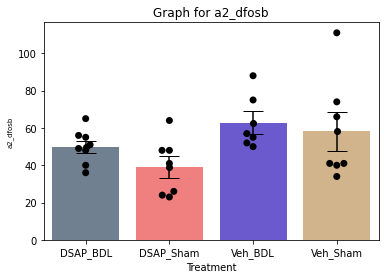



Two-Way ANOVA for a2_dfosb


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],445.292402,1.0,1.371089,0.253120
sap_project_data['injection'],1762.304124,1.0,5.426267,0.028577
sap_project_data['surgery']:sap_project_data['injection'],65.862543,1.0,0.202796,0.656515
Residual,7794.547619,24.0,NaN,NaN


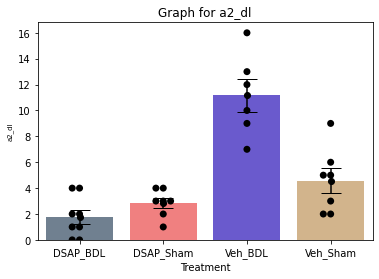



Two-Way ANOVA for a2_dl


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],42.354144,1.0,9.003159,6.197980e-03
sap_project_data['injection'],211.558174,1.0,44.970611,6.169030e-07
sap_project_data['surgery']:sap_project_data['injection'],102.751350,1.0,21.841704,9.525061e-05
Residual,112.904762,24.0,NaN,NaN


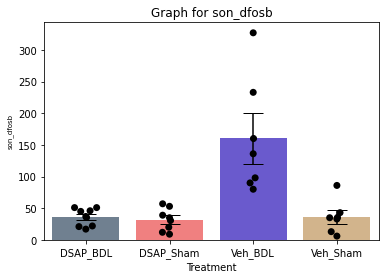



Two-Way ANOVA for son_dfosb


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],22511.947195,1.0,9.158694,0.006007
sap_project_data['injection'],28944.298843,1.0,11.775613,0.002277
sap_project_data['surgery']:sap_project_data['injection'],24176.362329,1.0,9.835840,0.004632
Residual,56533.690476,23.0,NaN,NaN


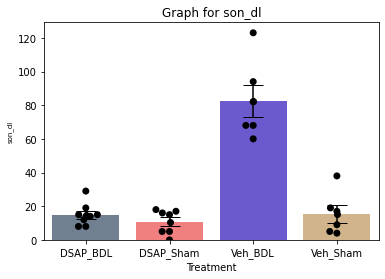



Two-Way ANOVA for son_dl


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],6991.267492,1.0,38.805783,2.347847e-06
sap_project_data['injection'],9079.269140,1.0,50.395461,3.126430e-07
sap_project_data['surgery']:sap_project_data['injection'],6606.892032,1.0,36.672265,3.550018e-06
Residual,4143.690476,23.0,NaN,NaN


In [66]:
for column in column_names:
  draw_graphs(data, column)